# [CS 6476 Project 2: Local Feature Matching and Camera Calibration]()

This iPython notebook:  
(1) Loads and resizes images  
(2) Finds interest points in those images                 (you code this)  
(3) Describes each interest point with a local feature    (you code this)  
(4) Naively finds matching features                       (you code this)  
(5) Computes projection matrices from 3D to 2D points     (you code this)   
(6) Determines camera fundamental matrices                (you code this)   
(7) Matches interest points using epipolar geometry       (you code this)   
(8) Visualizes the matches  
(9) Evaluates the matches based on ground truth correspondences  

## Set up

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


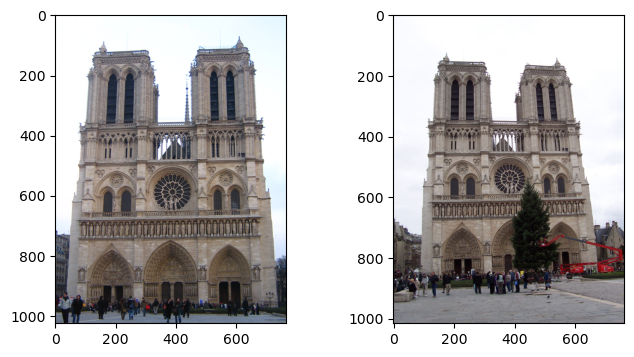

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# from vision.utils import load_image, PIL_resize, rgb2gray, normalize_img, verify
from vision.utils import (
    verify,
    evaluate_points,
    visualize_points,
    visualize_points_image,
    plot3dview,
    load_image,
    PIL_resize,
    rgb2gray,
    normalize_img,
    draw_epipolar_lines,
    get_matches,
    show_correspondence2,
)
from IPython.core.debugger import set_trace


%load_ext autoreload
%autoreload 2

# Notre Dame
image1 = load_image('./data/1a_notredame.jpg')
image2 = load_image('./data/1b_notredame.jpg')
eval_file = './ground_truth/notredame.pkl'

# # Mount Rushmore -- this pair is relatively easy (still harder than Notre Dame, though)
# image1 = load_image('./data/2a_rushmore.jpg')
# image2 = load_image('./data/2b_rushmore.jpg')
# eval_file = './ground_truth/rushmore.pkl'

# # Episcopal Gaudi -- This pair is relatively difficult
# image1 = load_image('./data/3a_gaudi.jpg')
# image2 = load_image('./data/3b_gaudi.jpg')
# eval_file = './ground_truth/gaudi.pkl'

# # Your own image pair (for part 5) -- replace the name with your file name. Note that there is no eval_file.
# image1 = load_image('./data/4a_myimage.jpg')
# image2 = load_image('./data/4b_myimage.jpg')

scale_factor = 0.5
image1 = PIL_resize(image1, (int(image1.shape[1]*scale_factor), int(image1.shape[0]*scale_factor)))
image2 = PIL_resize(image2, (int(image2.shape[1]*scale_factor), int(image2.shape[0]*scale_factor)))

image1_bw = rgb2gray(image1)
image2_bw = rgb2gray(image2)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(image1)
plt.subplot(1,2,2)
plt.imshow(image2)


# Part 1: Harris Corner Detector 
## Find distinctive points in each image

The Harris corner detector and SIFT rely heavily upon image gradient information. You'll implement `compute_image_gradients()` and then we'll visualize the magnitude of the image gradients. Which areas have highest mangitude, and why?

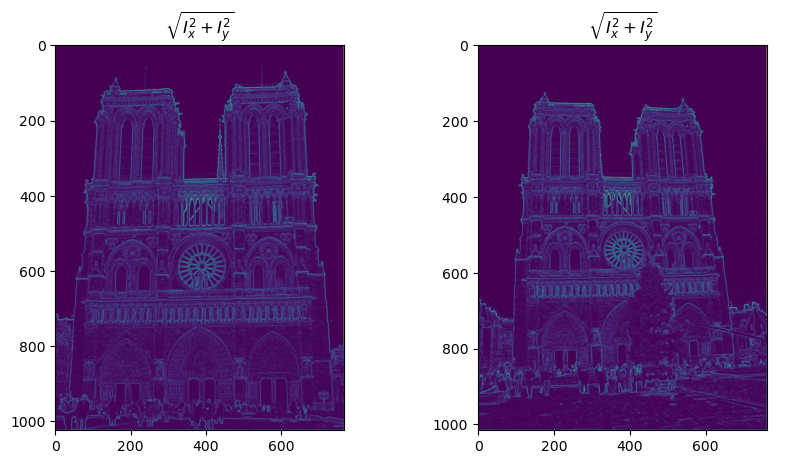

In [9]:
from vision.part1_harris_corner import compute_image_gradients
from tests.test_part1_harris_corner import test_compute_image_gradients

# print('compute_image_gradients(): ', verify(test_compute_image_gradients))

plt.figure(figsize=(10,5))
plt.axis('off')

Ix, Iy = compute_image_gradients(image1_bw)
gradient_magnitudes = np.sqrt(Ix**2 + Iy**2)
gradient_magnitudes = normalize_img(gradient_magnitudes)
plt.subplot(1,2,1)
plt.title(r'$\sqrt{I_x^2 + I_y^2}$')
plt.imshow( (gradient_magnitudes*255).astype(np.uint8))

Ix, Iy = compute_image_gradients(image2_bw)
gradient_magnitudes = np.sqrt(Ix**2 + Iy**2)
gradient_magnitudes = normalize_img(gradient_magnitudes)
plt.subplot(1,2,2)
plt.title(r'$\sqrt{I_x^2 + I_y^2}$')
plt.imshow( (gradient_magnitudes*255).astype(np.uint8))

We'll now compute the second moments $s_x^2, s_y^2, s_x s_y$ at each pixel, which aggregates gradient information in local neighborhoods. We'll use a 2d Gaussian filter to aggregate:

In [ ]:
from vision.part1_harris_corner import second_moments
sx2, sy2, sxsy = second_moments(image1_bw, ksize = 7, sigma = 10)

If we compare $s_x^2$, $s_y^2$, and $s_x s_y$ with $I_x$ and $I_y$, we see:

In [ ]:
from vision.utils import normalize_img

plt.figure(figsize=(12,9))
Ix, Iy = compute_image_gradients(image1_bw)
plt.subplot(2,3,1); plt.title(r'$I_x$')
plt.imshow( (normalize_img(np.abs(Ix))*255).astype(np.uint8))
plt.subplot(2,3,2); plt.title(r'$I_y$')
plt.imshow( (normalize_img(np.abs(Iy))*255).astype(np.uint8))

plt.subplot(2,3,4)
plt.title(r'$s_x^2$')
plt.imshow( (normalize_img(np.abs(sx2))*255).astype(np.uint8))

plt.subplot(2,3,5)
plt.title(r'$s_y^2$')
plt.imshow( (normalize_img(np.abs(sy2))*255).astype(np.uint8))

plt.subplot(2,3,6)
plt.title(r'$s_xs_y$')
plt.imshow( (normalize_img(np.abs(sxsy))*255).astype(np.uint8))

Note that $s_xs_y$ is highest where there are both strong x-direction and y-direction gradients (corners and the central rose window).

We'll now use these second moments to compute a "cornerness score" -- a corner response map -- as a function of these image gradients.

In [ ]:
from vision.part1_harris_corner import compute_harris_response_map
from tests.test_part1_harris_corner import test_compute_harris_response_map

print('compute_harris_response_map(): ', verify(test_compute_harris_response_map))

R = compute_harris_response_map(image1_bw)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image1_bw, cmap='gray')
plt.subplot(1,2,2)
plt.title(r'$R$')
plt.imshow(R)

The bright areas above are the areas of highest "corners".

We'll now implement non-max suppression to find local maxima in the 2d response map. One simple way to do non-maximum suppression is to simply pick a local maximum over some window size (u, v). This can be achieved using max-pooling.

In [ ]:
# run this cell to see the maxpool result
from vision.part1_harris_corner import maxpool_numpy
from tests.test_part1_harris_corner import test_maxpool_numpy, test_nms_maxpool_pytorch
from vision.utils import verify

# print('maxpool_numpy(): ', verify(test_maxpool_numpy))

toy_response_map = np.array(
[
    [1,2,2,1,2],
    [1,6,2,1,1],
    [2,2,1,1,1],
    [1,1,1,7,1],
    [1,1,1,1,1]
]).astype(np.float32)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(toy_response_map.astype(np.uint8))

plt.subplot(1,2,2)
maxpooled_image = maxpool_numpy(toy_response_map, ksize=3)
plt.imshow(maxpooled_image.astype(np.uint8))

Given a simple 5x5 grid of response scores, non-max suppression will allow us to choose values that are local maxima. If we request the top $k=2$ responses of the toy response grid above, we should get (1,1) and (3,3)

In [ ]:
from vision.part1_harris_corner import nms_maxpool_pytorch

print('nms_maxpool_pytorch(): ', verify(test_nms_maxpool_pytorch))

x_coords, y_coords, confidences = nms_maxpool_pytorch(toy_response_map, k=2, ksize=3)
print('Coordinates of local maxima:')
for x, y, c in zip(x_coords, y_coords, confidences):
    print(f'\tAt {x},{y}, local maximum w/ confidence={c:.2f}')

Here we will call the `get_harris_interest_points()` function in `part1_harris_corner.py` to detect 'interesting' points in the images. 

**IMPORTANT**
Make sure to add your code in the `get_harris_interest_points()` function to call Harris Corner Detector.

In [ ]:
from tests.test_part1_harris_corner import test_get_harris_interest_points, test_remove_border_vals

# print('test_remove_border_vals(): ', verify(test_remove_border_vals))

print('get_harris_interest_points()', verify(test_get_harris_interest_points))

In [ ]:
import copy
from vision.part1_harris_corner import get_harris_interest_points
from vision.utils import show_interest_points

num_interest_points = 2500
X1, Y1, _ = get_harris_interest_points( copy.deepcopy(image1_bw), num_interest_points)
X2, Y2, _ = get_harris_interest_points( copy.deepcopy(image2_bw), num_interest_points)

num_pts_to_visualize = 300
# Visualize the interest points
rendered_img1 = show_interest_points(image1, X1[:num_pts_to_visualize], Y1[:num_pts_to_visualize])
rendered_img2 = show_interest_points(image2, X2[:num_pts_to_visualize], Y2[:num_pts_to_visualize])
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(rendered_img1)
plt.subplot(1,2,2); plt.imshow(rendered_img2)
print(f'{len(X1)} corners in image 1, {len(X2)} corners in image 2')

## Part 2: Feature matching (Szeliski 7.1.3)

Perhaps the simplest possible keypoint descriptor is to stack the 16x16 patch surrounding the keypoint into a 256-dimensional vector, and normalize it.

In [ ]:
from vision.utils import compute_normalized_patch_descriptors

image1_features = compute_normalized_patch_descriptors(image1_bw, X1, Y1, feature_width=16)
image2_features = compute_normalized_patch_descriptors(image2_bw, X2, Y2, feature_width=16)

# Visualize what the first 300 feature vectors for image 1 look like (they should not be identical or all black)
plt.figure()
plt.subplot(1,2,1); plt.imshow(image1_features[:300])

In [ ]:
#test your feature matching implementation
from tests.test_part2_feature_matching import (
    test_match_features_ratio_test,
    test_compute_feature_distances_2d,
    test_compute_feature_distances_10d
)
print('compute_feature_distances (2d):', verify(test_compute_feature_distances_2d))
print('compute_feature_distances (10d):', verify(test_compute_feature_distances_10d))
print('match_features_ratio_test:', verify(test_match_features_ratio_test))

In [ ]:
from vision.part2_feature_matching import match_features_ratio_test

matches, confidences = match_features_ratio_test(image1_features, image2_features)
print('{:d} matches from {:d} corners'.format(len(matches), len(X1)))

## Visualization

You might want to set 'num_pts_to_visualize' and 'num_pts_to_evaluate' to some constant (e.g. 100) once you start detecting hundreds of interest points, otherwise things might get too cluttered. You could also threshold based on confidence.  
  
There are two visualization functions below. You can comment out one of both of them if you prefer.

NOTE: If you find that no matches are returned, you may encounter an error in the cells below. To avoid this, adjust your threshold in `match_features_ratio_test` to include at least one match.

In [ ]:
import os
from vision.utils import show_correspondence_circles, show_correspondence_lines
os.makedirs('./results', exist_ok=True)
# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 200
c1 = show_correspondence_circles(image1, image2,
                    X1[matches[:num_pts_to_visualize, 0]], Y1[matches[:num_pts_to_visualize, 0]],
                    X2[matches[:num_pts_to_visualize, 1]], Y2[matches[:num_pts_to_visualize, 1]])
plt.figure(figsize=(10,5)); plt.imshow(c1)
plt.savefig('./results/vis_circles.jpg', dpi=1000)
c2 = show_correspondence_lines(image1, image2,
                    X1[matches[:num_pts_to_visualize, 0]], Y1[matches[:num_pts_to_visualize, 0]],
                    X2[matches[:num_pts_to_visualize, 1]], Y2[matches[:num_pts_to_visualize, 1]])
plt.figure(figsize=(10,5)); plt.imshow(c2)
plt.savefig('./results/vis_lines.jpg', dpi=1000)

Comment out the function below if you are not testing on the Notre Dame, Episcopal Gaudi, and Mount Rushmore image pairs--this evaluation function will only work for those which have ground truth available.  

In [ ]:
from vision.utils import evaluate_correspondence
# num_pts_to_evaluate = len(matches)
num_pts_to_evaluate = 2500
_, c = evaluate_correspondence(image1, image2, eval_file, scale_factor,
                        X1[matches[:num_pts_to_evaluate, 0]], Y1[matches[:num_pts_to_evaluate, 0]],
                        X2[matches[:num_pts_to_evaluate, 1]], Y2[matches[:num_pts_to_evaluate, 1]])
plt.figure(figsize=(8,4)); plt.imshow(c)
plt.savefig('./results/eval.jpg', dpi=1000)

# Part 3: Sift Feature Descriptor (Szeliski 7.1.2)
SIFT relies upon computing the magnitudes and orientations of image gradients, and then computing weighted histograms.

In [ ]:
from tests.test_part3_sift_descriptor import (
    test_get_magnitudes_and_orientations,
    test_get_gradient_histogram_vec_from_patch
)
print('get_magnitudes_and_orientations:', verify(test_get_magnitudes_and_orientations))

In [ ]:
print('get_gradient_histogram_vec_from_patch():', verify(test_get_gradient_histogram_vec_from_patch))

In [ ]:
from tests.test_part3_sift_descriptor import test_get_feat_vec, test_get_SIFT_descriptors
print(verify(test_get_feat_vec))
print(verify(test_get_SIFT_descriptors))

In [ ]:
from vision.part3_sift_descriptor import get_SIFT_descriptors

import time
start = time.time()
image1_features = get_SIFT_descriptors(image1_bw, X1, Y1)
image2_features = get_SIFT_descriptors(image2_bw, X2, Y2)
end = time.time()
duration = end - start
print(f'SIFT took {duration} sec.')

# visualize what the values of the first 200 SIFT feature vectors look like (should not be identical or all black)
plt.figure(); plt.subplot(1,2,1); plt.imshow(image1_features[:200])

In [ ]:
from vision.utils import show_correspondence_circles, show_correspondence_lines

matches, confidences = match_features_ratio_test(image1_features, image2_features)
print('{:d} matches from {:d} corners'.format(len(matches), len(X1)))

# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 200
c1 = show_correspondence_circles(
    image1,
    image2,
    X1[matches[:num_pts_to_visualize, 0]],
    Y1[matches[:num_pts_to_visualize, 0]],
    X2[matches[:num_pts_to_visualize, 1]],
    Y2[matches[:num_pts_to_visualize, 1]]
)
plt.figure(figsize=(10,5)); plt.imshow(c1)
plt.savefig('./results/vis_circles.jpg', dpi=1000)
c2 = show_correspondence_lines(
    image1,
    image2,
    X1[matches[:num_pts_to_visualize, 0]],
    Y1[matches[:num_pts_to_visualize, 0]],
    X2[matches[:num_pts_to_visualize, 1]],
    Y2[matches[:num_pts_to_visualize, 1]]
)
plt.figure(figsize=(10,5)); plt.imshow(c2)
plt.savefig('./results/vis_lines.jpg', dpi=1000)

In [ ]:
from vision.utils import evaluate_correspondence
num_pts_to_evaluate = len(matches)
_, c = evaluate_correspondence(
    image1,
    image2,
    eval_file,
    scale_factor,
    X1[matches[:num_pts_to_evaluate, 0]],
    Y1[matches[:num_pts_to_evaluate, 0]],
    X2[matches[:num_pts_to_evaluate, 1]],
    Y2[matches[:num_pts_to_evaluate, 1]]
)
plt.figure(figsize=(8,4)); plt.imshow(c)
plt.savefig('./results/eval.jpg', dpi=1000)

Ensure your code runs in under 90 sec and achieves >80% acc on the Notre Dame pair:

In [ ]:
from tests.test_part3_sift_descriptor import (
    test_feature_matching_speed,
    test_feature_matching_accuracy
)
print('SIFT pipeline speed test:', verify(test_feature_matching_speed))
print('SIFT pipeline accuracy test:', verify(test_feature_matching_accuracy))

## Part 4: Camera Projection Matrix

In [ ]:
# Load the data
img_path = "data/CCB_GaTech/pic_a.jpg"
points_2d = np.loadtxt("data/CCB_GaTech/pts2d-norm-pic_a.txt")
points_3d = np.loadtxt("data/CCB_GaTech/pts3d-norm.txt")

# (Optional) Uncomment these four lines once you have your code working with the easier, normalized points above.
# points_2d = np.loadtxt('../data/CCB_GaTech/pts2d-pic_b.txt')
# points_3d = np.loadtxt('../data/CCB_GaTech/pts3d.txt')

### Calculate the projection matrix given corresponding 2D & 3D points

In [ ]:
from vision.part4_projection_matrix import (
    calculate_projection_matrix,
    calculate_camera_center,
)

from tests.test_part4_projection_matrix import (
    test_projection,
    test_calculate_projection_matrix,
    test_calculate_camera_center,
)

In [ ]:
print("projection():", verify(test_projection))

In [ ]:
M = calculate_projection_matrix(points_2d, points_3d)
print("The projection matrix is\n", M)

[projected_2d_pts, residual] = evaluate_points(M, points_2d, points_3d)
print("The total residual is {:f}".format(residual))
plt.figure()
plt.imshow(load_image(img_path))
visualize_points(points_2d, projected_2d_pts)

In [ ]:
print("calculate_projection_matrix():", verify(test_calculate_projection_matrix))

### Calculate the camera center using M found from the previous step

In [ ]:
center = calculate_camera_center(M)
print(
    "The estimated location of the camera is <{:.4f}, {:.4f}, {:.4f}>".format(*center)
)
plt.figure()
plt.imshow(load_image(img_path))
ax = plot3dview(points_3d, center)

In [ ]:
print("test_calculate_camera_center():", verify(test_calculate_camera_center))

## Camera Calibration for Argoverse image data
We'll now estimate the position of a camera mounted on an autonomous vehicle, using data from Argoverse. We'll use images from the "ring front center" camera, which faces forward.


<img src="https://www.argoverse.org/assets/images/reference_images/O2V4_vehicle_annotation.jpg" alt="Drawing" style="width: 400px;"/>


In [ ]:
# Argoverse Scene 3
img_path = "data/argoverse_log_d60558d2_pair3/pic3.jpg"
points_2d = np.loadtxt("data/argoverse_log_d60558d2_pair3/points_2d.txt")
points_3d = np.loadtxt("data/argoverse_log_d60558d2_pair3/points_3d.txt")
# # # Argoverse Scene 2
# img_path = '../data/argoverse_log_d60558d2_pair2/pic2.jpg'
# points_2d = np.loadtxt('../data/argoverse_log_d60558d2_pair2/points_2d.txt')
# points_3d = np.loadtxt('../data/argoverse_log_d60558d2_pair2/points_3d.txt')

In [ ]:
M = calculate_projection_matrix(points_2d, points_3d)
print("The projection matrix is\n", M)

[projected_2d_pts, residual] = evaluate_points(M, points_2d, points_3d)
print("The total residual is {:f}".format(residual))
plt.figure()
plt.imshow(load_image(img_path))
visualize_points(points_2d, projected_2d_pts)

For these 2d-3d pairs, the "world" frame is defined as the "ego-vehicle" frame, where the origin is at the center of the back axle of the vehicle.

Thus, if your camera center estimate is correct, it should tell you how far to move forward (+x) and how far to move left (+y) and move up (+z) to reach teh camera's position.


The "egovehicle" coordinate system and "camera" coordinate system:
<img width="300"  src="https://user-images.githubusercontent.com/16724970/108759169-034e6180-751a-11eb-8a06-fbe344f1ee68.png">
<img width="300" src="https://user-images.githubusercontent.com/16724970/108759182-06495200-751a-11eb-8162-8b17f9cdee4b.png">

In [ ]:
center = calculate_camera_center(M)
print(
    "The estimated location of the camera is <{:.4f}, {:.4f}, {:.4f}>".format(*center)
)
plt.figure()
plt.imshow(load_image(img_path))
ax = plot3dview(points_3d, center)
ax.view_init(elev=15, azim=180)

## Part 5: Fundamental Matrix Estimation
We'll now solve for the Fundamental Matrix by implementing [Hartley's 8-Point algorithm](https://www.cse.unr.edu/~bebis/CS485/Handouts/hartley.pdf).

Please visualize the results for both Gaudi and Notre Dame for your report.

In [ ]:
from vision.part5_fundamental_matrix import estimate_fundamental_matrix

In [ ]:
# Load the data

# Notre Dame
points_2d_pic_a = np.loadtxt("data/Notre_Dame/pts2d-pic_a.txt")
points_2d_pic_b = np.loadtxt("data/Notre_Dame/pts2d-pic_b.txt")
img_a = load_image("data/Notre_Dame/921919841_a30df938f2_o.jpg")
img_b = load_image("data/Notre_Dame/4191453057_c86028ce1f_o.jpg")

# Gaudi
# points_2d_pic_a = np.loadtxt("data/Episcopal_Gaudi/pts2d-pic_a.txt")
# points_2d_pic_b = np.loadtxt("data/Episcopal_Gaudi/pts2d-pic_b.txt")
# img_a = load_image('data/Episcopal_Gaudi/3743214471_1b5bbfda98_o.jpg');
# img_b = load_image('data/Episcopal_Gaudi/4386465943_8cf9776378_o.jpg');

### Estimate fundamental matrix

In [ ]:
from tests.test_part5_fundamental_matrix import (
    test_estimate_fundamental_matrix,
    test_normalize_points,
    test_unnormalize_F,
)

print("test_estimate_fundamental_matrix():", verify(test_estimate_fundamental_matrix))
print("test_normalize_points():", verify(test_normalize_points))
print("test_unnormalize_F():", verify(test_unnormalize_F))

In [ ]:
F = estimate_fundamental_matrix(points_2d_pic_a, points_2d_pic_b)

# Draw epipolar lines using the fundamental matrix
draw_epipolar_lines(F, img_a, img_b, points_2d_pic_a, points_2d_pic_b, figsize=(13, 4))

## Part 6: Fundamental Matrix with RANSAC (Szeliski 6.1.4)

**Mount Rushmore**: This pair is easy, and most of the initial matches are correct. The base fundamental matrix estimation without coordinate normalization will work fine with RANSAC. 

**Notre Dame**: This pair is difficult because the keypoints are largely on the same plane. Still, even an inaccurate fundamental matrix can do a pretty good job of filtering spurious matches.  

**Gaudi**: This pair is difficult and doesn't find many correct matches unless you run at high resolution, but that will lead to tens of thousands of SIFT features, which will be somewhat slow to process. Normalizing the coordinates seems to make this pair work much better.  

**Woodruff**: This pair has a clearer relationship between the cameras (they are converging and have a wide baseline between them). The estimated fundamental matrix is less ambiguous and you should get epipolar lines qualitatively similar to part 2 of the project.

In [ ]:
from vision.part6_ransac import (
    calculate_num_ransac_iterations,
    ransac_fundamental_matrix,
)
from vision.utils import single2im

In [ ]:
# Load the data
# Mount Rushmore
pic_a = single2im(load_image('data/Mount_Rushmore/9193029855_2c85a50e91_o.jpg'))
scale_a = 0.25
pic_b = single2im(load_image('data/Mount_Rushmore/7433804322_06c5620f13_o.jpg'))
scale_b = 0.37
n_feat = 5e4

# Notre Dame
# pic_a = single2im(load_image("data/Notre_Dame/921919841_a30df938f2_o.jpg"))
# scale_a = 0.5
# pic_b = single2im(load_image("data/Notre_Dame/4191453057_c86028ce1f_o.jpg"))
# scale_b = 0.5
# n_feat = 4e3

# Gaudi
# pic_a = single2im(load_image('data/Episcopal_Gaudi/3743214471_1b5bbfda98_o.jpg')); scale_a = 0.8
# pic_b = single2im(load_image('data/Episcopal_Gaudi/4386465943_8cf9776378_o.jpg')); scale_b = 1.0
# n_feat = 2e4

# Woodruff
# pic_a = single2im(load_image('data/Woodruff_Dorm/wood1.jpg')); scale_a = 0.65
# pic_b = single2im(load_image('data/Woodruff_Dorm/wood2.jpg')); scale_b = 0.65
# n_feat = 5e4

pic_a = cv2.resize(pic_a, None, fx=scale_a, fy=scale_a)
pic_b = cv2.resize(pic_b, None, fx=scale_b, fy=scale_b)
print(pic_a.shape)

In [ ]:
# Finds matching points in the two images using OpenCV's implementation of SIFT.
# There can still be many spurious matches, though.
points_2d_pic_a, points_2d_pic_b = get_matches(pic_a, pic_b, n_feat)
print("Found {:d} possibly matching features".format(len(points_2d_pic_a)))
match_image = show_correspondence2(
    pic_a,
    pic_b,
    points_2d_pic_a[:, 0],
    points_2d_pic_a[:, 1],
    points_2d_pic_b[:, 0],
    points_2d_pic_b[:, 1],
)
plt.figure()
plt.imshow(match_image)
plt.tight_layout()

### Calculate the Fundamental Matrix using RANSAC
Compare your results on the Notre Dame image pair below to your results from Part 2. How accurate do the point correspondences look now? 

In [ ]:
F, matched_points_a, matched_points_b = ransac_fundamental_matrix(
    points_2d_pic_a, points_2d_pic_b
)

# Draw the epipolar lines on the images and corresponding matches
match_image = show_correspondence2(
    pic_a,
    pic_b,
    matched_points_a[:, 0],
    matched_points_a[:, 1],
    matched_points_b[:, 0],
    matched_points_b[:, 1],
)
plt.figure()
plt.imshow(match_image)
plt.tight_layout()

In [ ]:
draw_epipolar_lines(
    F, pic_a, pic_b, matched_points_a, matched_points_b, figsize=(12, 8)
)

In [ ]:
from tests.test_part6_ransac import (
    test_calculate_num_ransac_iterations,
    test_ransac_fundamental_matrix,
)

print(
    "test_calculate_num_ransac_iterations():",
    verify(test_calculate_num_ransac_iterations),
)
print("test_ransac_fundamental_matrix():", verify(test_ransac_fundamental_matrix))

### Performance Comparison
We'll now test the quality of Fundamental matrices we can compute with and without RANSAC on an image pair from the [Argoverse](https://www.argoverse.org/) autonomous driving dataset. Does RANSAC improve the results?

In [ ]:
from vision.part6_ransac import (
    calculate_num_ransac_iterations,
    ransac_fundamental_matrix,
)

In [ ]:
pic_a = single2im(load_image(
    "data/argoverse_log_273c1883/ring_front_center_315975640448534784.jpg"
))
scale_a = 0.5
pic_b = single2im(load_image(
    "data/argoverse_log_273c1883/ring_front_center_315975643412234000.jpg"
))
scale_b = 0.5

n_feat = 4e3
num_matches_to_plot = 50

pic_a = cv2.resize(pic_a, None, fx=scale_a, fy=scale_a)
pic_b = cv2.resize(pic_b, None, fx=scale_b, fy=scale_b)

In [ ]:
points_2d_pic_a, points_2d_pic_b = get_matches(pic_a, pic_b, n_feat)

print("Found {:d} possibly matching features".format(len(points_2d_pic_a)))
match_image = show_correspondence2(
    pic_a,
    pic_b,
    points_2d_pic_a[:num_matches_to_plot, 0],
    points_2d_pic_a[:num_matches_to_plot, 1],
    points_2d_pic_b[:num_matches_to_plot, 0],
    points_2d_pic_b[:num_matches_to_plot, 1],
)
plt.figure(figsize=(14, 6))
plt.imshow(match_image)

### Without RANSAC Estimation
If we ignore RANSAC and use only our implementation from Part2, we get the following results:

In [ ]:
F_wo_ransac = estimate_fundamental_matrix(points_2d_pic_a, points_2d_pic_b)

# Draw epipolar lines using the fundamental matrix
draw_epipolar_lines(
    F_wo_ransac, pic_a, pic_b, points_2d_pic_a, points_2d_pic_b, figsize=(13, 4)
)

### With Ransac Estimation
Now we'll use our RANSAC implementation from Part 3. Where does the epipole fall in the left image? (think about what it represents). The camera is mounted on an autonomous vehicle identical to the vehicle seen up ahead in the left image.

In [ ]:
F, matched_points_a, matched_points_b = ransac_fundamental_matrix(
    points_2d_pic_a, points_2d_pic_b
)

draw_epipolar_lines(
    F, pic_a, pic_b, matched_points_a, matched_points_b, figsize=(13, 4)
)

match_image = show_correspondence2(
    pic_a,
    pic_b,
    points_2d_pic_a[:num_matches_to_plot, 0],
    points_2d_pic_a[:num_matches_to_plot, 1],
    points_2d_pic_b[:num_matches_to_plot, 0],
    points_2d_pic_b[:num_matches_to_plot, 1],
)
plt.figure(figsize=(14, 4))
plt.imshow(match_image)